In [104]:
import warnings

In [105]:
warnings.filterwarnings('ignore')

In [106]:
!pip install dash dash-bootstrap-components

In [107]:
!pip install gdown

In [108]:
!gdown --id FILE_ID --output val2017.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=FILE_ID

but Gdown can't. Please check connections and permissions.


In [109]:
!unzip val2017.zip -d ./coco

unzip:  cannot find or open val2017.zip, val2017.zip.zip or val2017.zip.ZIP.


In [110]:
import torch

In [111]:
import torchvision.transforms as transforms

In [112]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [113]:
from pycocotools.coco import COCO

In [114]:
import cv2

In [115]:
import matplotlib.pyplot as plt

In [116]:
import numpy as np

In [117]:
import os

In [118]:
import requests

In [119]:
import zipfile

In [120]:
from torch.utils.data import DataLoader, Dataset

In [121]:
from sklearn.metrics import precision_score, recall_score, average_precision_score

In [122]:
import dash

In [123]:
from dash import dcc, html, Input, Output

In [124]:
import dash_bootstrap_components as dbc

In [125]:
import plotly.express as px

In [126]:
import base64

In [127]:
# Step 1: Data Loading and Preprocessing

In [128]:
def download_coco(root_dir='./coco'):
    urls = [
        'http://images.cocodataset.org/zips/val2017.zip',
        'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    ]
    os.makedirs(root_dir, exist_ok=True)
    for url in urls:
        filename = os.path.join(root_dir, url.split('/')[-1])
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            with requests.get(url, stream=True) as r, open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):
                    f.write(chunk)
            print(f"{filename} downloaded.")

    for file in os.listdir(root_dir):
        if file.endswith('.zip'):
            zip_path = os.path.join(root_dir, file)
            print(f"Extracting {zip_path}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(root_dir)
            print(f"{zip_path} extracted.")


In [129]:
def load_coco_dataset(dataset_dir='coco'):
    annotation_file = os.path.join(dataset_dir, 'annotations', 'instances_val2017.json')
    if not os.path.exists(annotation_file):
        print("COCO dataset not found. Please download it manually or use the download_coco function.")
    return COCO(annotation_file)


# **OR**

In [130]:
def load_coco_dataset(dataset_dir='coco'):
    annotation_file = os.path.join(dataset_dir, 'annotations', 'instances_val2017.json')
    if not os.path.exists(annotation_file):
        print("COCO dataset not found. Please download it manually or use the download_coco function.")
    coco = COCO(annotation_file)

    # Exploratory Data Analysis (EDA)
    print("Number of Images:", len(coco.getImgIds()))
    print("Number of Annotations:", len(coco.getAnnIds()))
    categories = coco.loadCats(coco.getCatIds())
    category_names = [cat['name'] for cat in categories]
    print("Categories:", category_names)

    img_ids = coco.getImgIds()[:5]
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        print(f"Image ID: {img_id}, File: {img_info['file_name']}, Width: {img_info['width']}, Height: {img_info['height']}")

    return coco


In [131]:
# Step 2: YOLOv3 Model Setup

In [132]:
def load_model():
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.eval()
    return model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [133]:
# Step 3: Image Preprocessing

In [134]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((416, 416)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

In [135]:
# Step 4: Object Detection

In [136]:
def detect_objects(model, img_tensor, threshold=0.6):
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    boxes, labels, scores = predictions['boxes'], predictions['labels'], predictions['scores']
    mask = scores > threshold
    return boxes[mask], labels[mask], scores[mask]


In [137]:
# Step 5: Visualization

In [138]:
def visualize_detections(img_path, boxes, labels, scores, coco):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {img_path}")
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, box.cpu().numpy())
        class_name = coco.loadCats(int(label))[0]['name']
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{class_name} {score:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [139]:
# Step 6: Model Evaluation

In [140]:
def evaluate_model(model, coco, image_dir='coco/val2017'):
    y_true, y_pred = [], []
    img_ids = coco.getImgIds()[:20]
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        try:
            img_tensor = preprocess_image(img_path).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            boxes, labels, scores = detect_objects(model, img_tensor)
            true_ann = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
            true_labels = [ann['category_id'] for ann in true_ann]
            pred_labels = labels.cpu().numpy().tolist()
            y_true.extend(true_labels)
            y_pred.extend(pred_labels)
        except Exception as e:
            print(f"Skipping image {img_path}: {e}")
    print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("Average Precision:", average_precision_score(y_true, y_pred, average='macro'))


# Main workflow

In [141]:
download_coco()

Extracting ./coco/annotations_trainval2017.zip...
./coco/annotations_trainval2017.zip extracted.
Extracting ./coco/val2017.zip...
./coco/val2017.zip extracted.


In [142]:
coco = load_coco_dataset()

loading annotations into memory...
Done (t=2.55s)
creating index...
index created!
Number of Images: 5000
Number of Annotations: 36781
Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toot

In [143]:
model = load_model()

In [144]:
img_path = 'coco/val2017/000000000139.jpg'


In [145]:
img_tensor = preprocess_image(img_path).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [146]:
boxes, labels, scores = detect_objects(model, img_tensor)

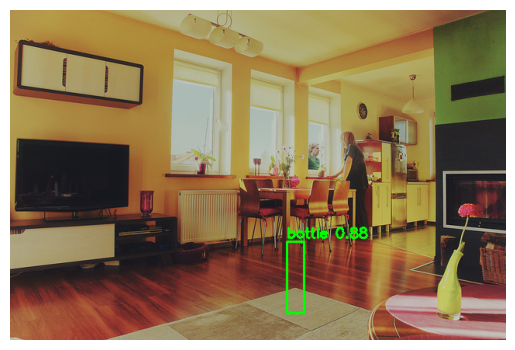

In [147]:
visualize_detections(img_path, boxes, labels, scores, coco)

---
---
---

# **INTERACTIVE DASHBOARD**

In [148]:
# Initialize Dash app

In [149]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

In [150]:
# Load model

In [151]:
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [152]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [154]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [155]:
# Load COCO dataset

In [156]:
coco = COCO('coco/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [157]:
# Image preprocessing

In [158]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((416, 416)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

In [159]:
# Object detection

In [160]:
def detect_objects(model, img_tensor, threshold=0.6):
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    boxes, labels, scores = predictions['boxes'], predictions['labels'], predictions['scores']
    mask = scores > threshold
    return boxes[mask], labels[mask], scores[mask]

In [161]:
# Visualization

In [162]:
def visualize_detections(img_path, boxes, labels, scores):
    img = cv2.imread(img_path)
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, box.cpu().numpy())
        class_name = coco.loadCats(int(label))[0]['name']
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{class_name} {score:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    _, img_encoded = cv2.imencode('.jpg', img)
    return base64.b64encode(img_encoded).decode('utf-8')


In [163]:
# Layout

In [164]:
app.layout = dbc.Container([
    dbc.Row([html.H2("Faster R-CNN Object Detection Dashboard")]),
    dbc.Row([
        dcc.Upload(
            id='upload-image',
            children=html.Div(['Drag and Drop or ', html.A('Select an Image')]),
            style={
                'width': '100%', 'height': '60px', 'lineHeight': '60px',
                'borderWidth': '1px', 'borderStyle': 'dashed', 'borderRadius': '5px',
                'textAlign': 'center', 'margin': '10px'
            },
            multiple=False
        )
    ]),
    dbc.Row([html.Div(id='output-image')]),
    dbc.Row([html.Div(id='detection-results')]),
])

@app.callback(
    [Output('output-image', 'children'), Output('detection-results', 'children')],
    [Input('upload-image', 'contents')]
)
def update_output(contents):
    if contents is None:
        return "", ""
    # Decode and save the uploaded image
    content_type, content_string = contents.split(',')
    img_data = base64.b64decode(content_string)
    img_path = "uploaded_image.jpg"
    with open(img_path, "wb") as f:
        f.write(img_data)

    img_tensor = preprocess_image(img_path).to(device)
    boxes, labels, scores = detect_objects(model, img_tensor)
    img_base64 = visualize_detections(img_path, boxes, labels, scores)

    img_element = html.Img(src='data:image/jpeg;base64,' + img_base64, style={'width': '100%'})

    results = [
        html.Ul([
            html.Li(f"Label: {coco.loadCats(int(label))[0]['name']}, Score: {score:.2f}")
            for label, score in zip(labels, scores)
        ])
    ]
    return img_element, results

In [166]:
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

---
---
---